In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction

In [163]:
df = pd.read_pickle("../../data/intermediate/02_outliers_removed_chauvenets.pkl")

In [164]:
predictor_columns = list(df.columns[:6])
predictor_columns


# Plotting settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [165]:
# Dealing with missing values (imputation)
for col in predictor_columns:
    df[col] = df[col].interpolate()

In [166]:
# Calculating set duration
#df[df["set"] == 25]["acc_y"].plot();

# Duration for a single set
duration = df[df["set"] == 1].index[-1] - df[df["set"] == 1].index[0]


for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    end = df[df["set"] == s].index[-1]

    duration = end - start

    # Add duration to dataframe
    df.loc[(df["set"] == s), "duration"] = duration.seconds


In [167]:
df.groupby(["category"])["duration"].mean()

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [168]:
# Butterworth lowpass filter
df_lowpass = df.copy()
LowPass = LowPassFilter()

# step size 200
fs = 1000 / 200
cutoff = 1.3 #low number smooth data

df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order = 5)

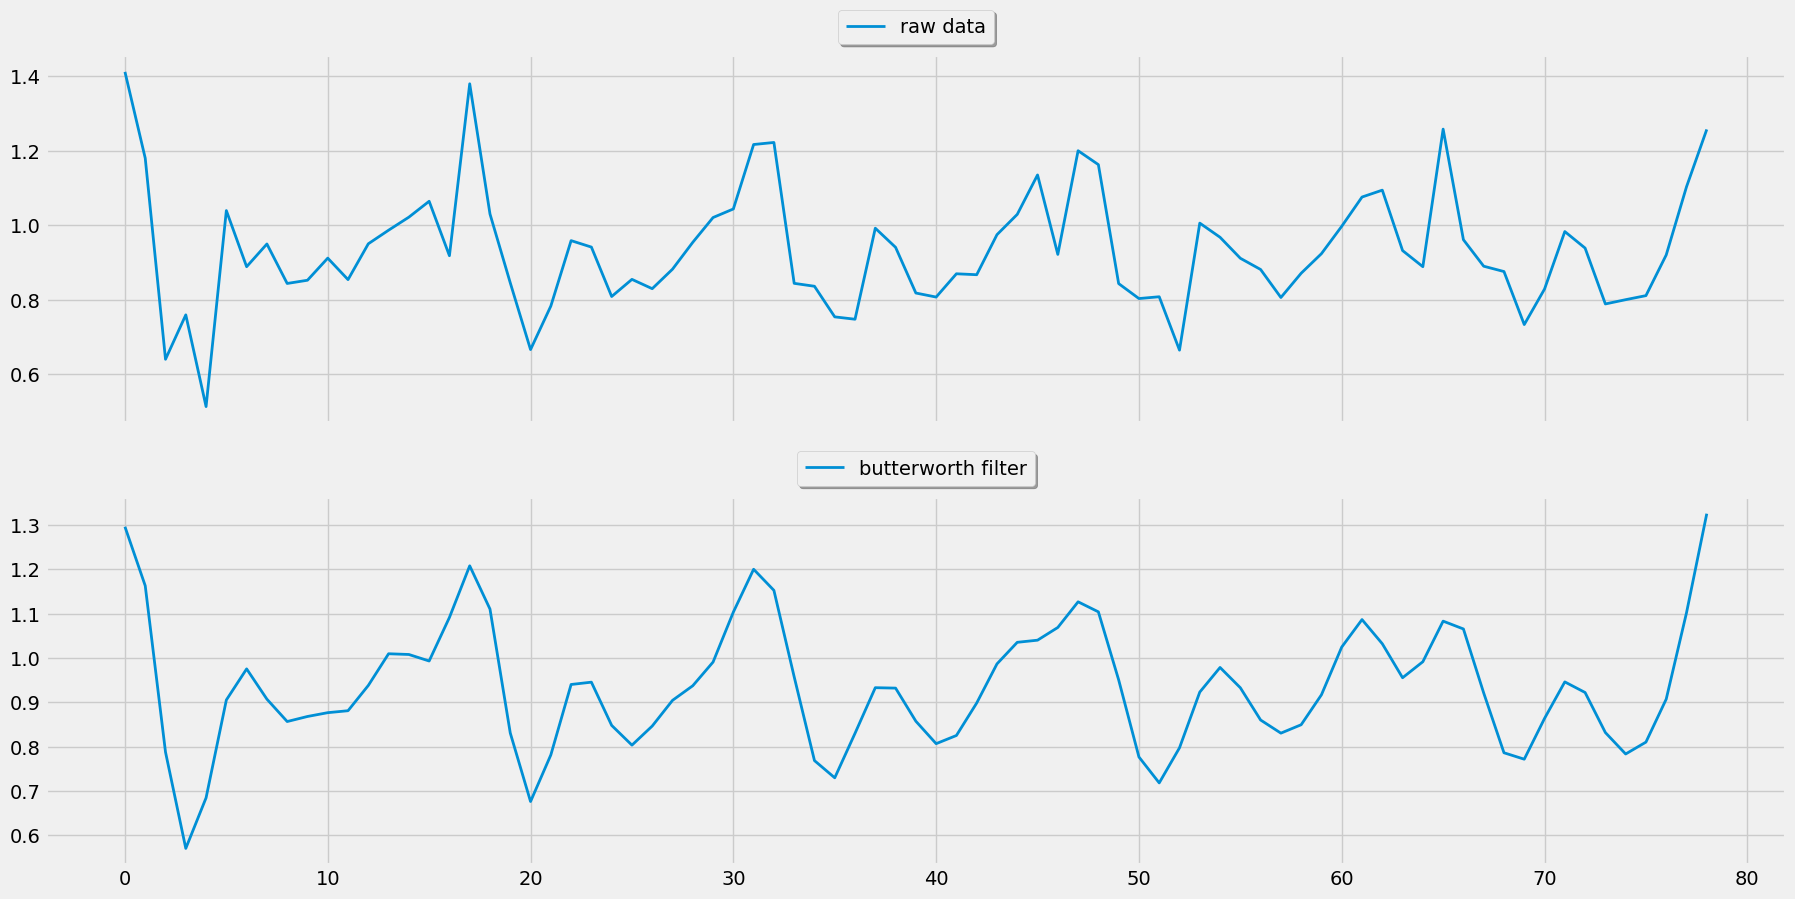

In [169]:
# Visualize
subset = df_lowpass[df_lowpass["set"] == 45]

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data");
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter");
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True);
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True);



In [170]:
# Apply this to whole data
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order = 5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

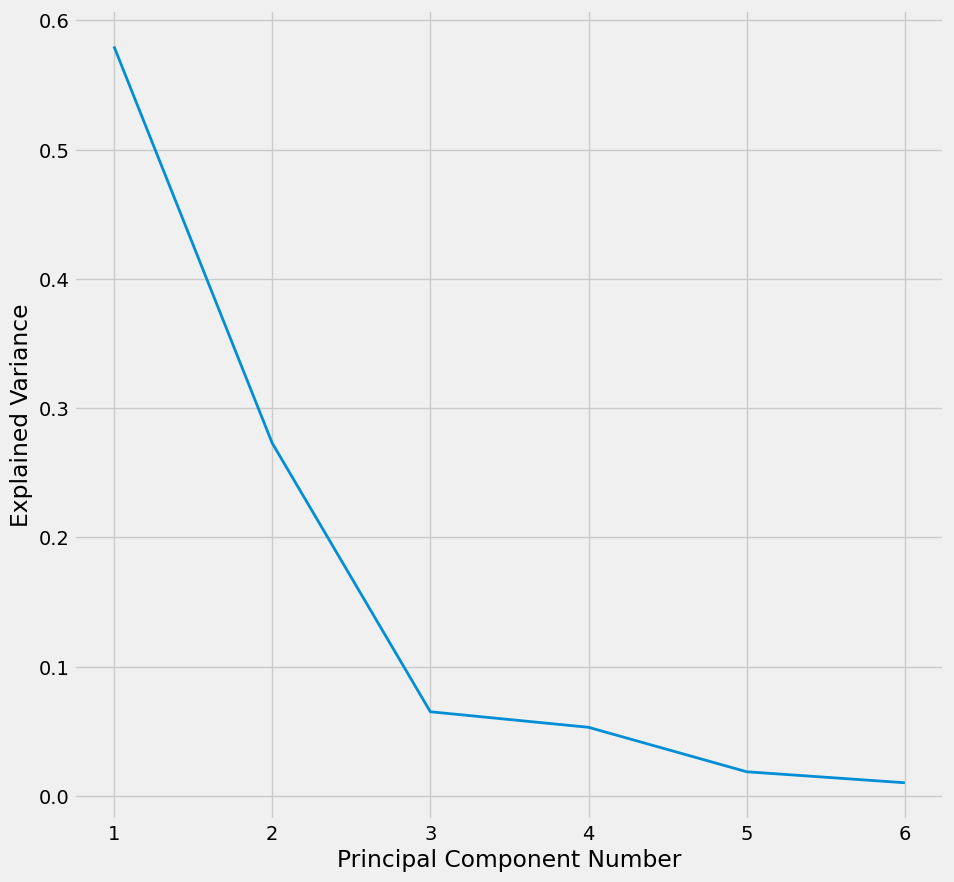

In [171]:
# Principal component analysis PCA
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pca_values = PCA.determine_pc_explained_variance(df_pca,predictor_columns)

plt.figure(figsize=(10,10))
plt.plot(range(1, len(predictor_columns) + 1), pca_values)
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance")
plt.show();

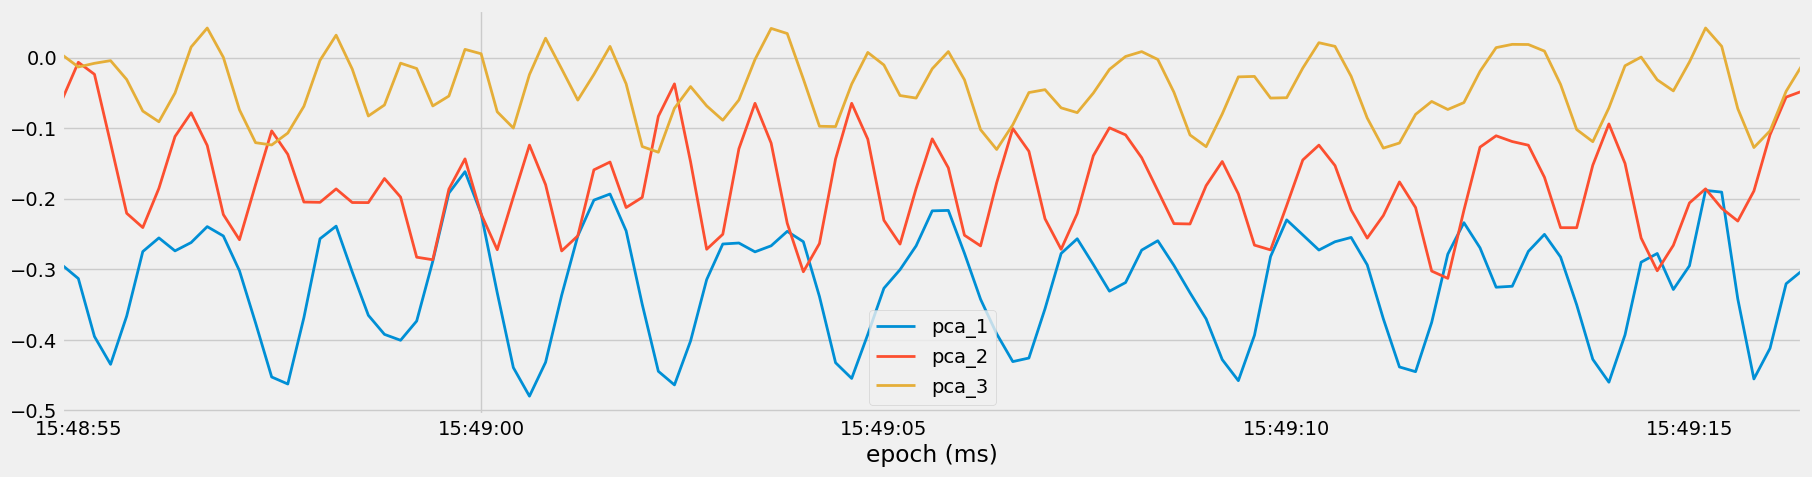

In [172]:
df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)


subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot();

In [173]:
# Sum of squares attributes

df_sos = df_pca.copy()
acc_sos = df["acc_x"] ** 2 + df["acc_y"] ** 2 + df["acc_z"] ** 2 
gyr_sos = df["gyr_x"] ** 2 + df["gyr_y"] ** 2 + df["gyr_z"] ** 2 

df_sos["acc_sos"] = np.sqrt(acc_sos)
df_sos["gyr_sos"] = np.sqrt(gyr_sos)

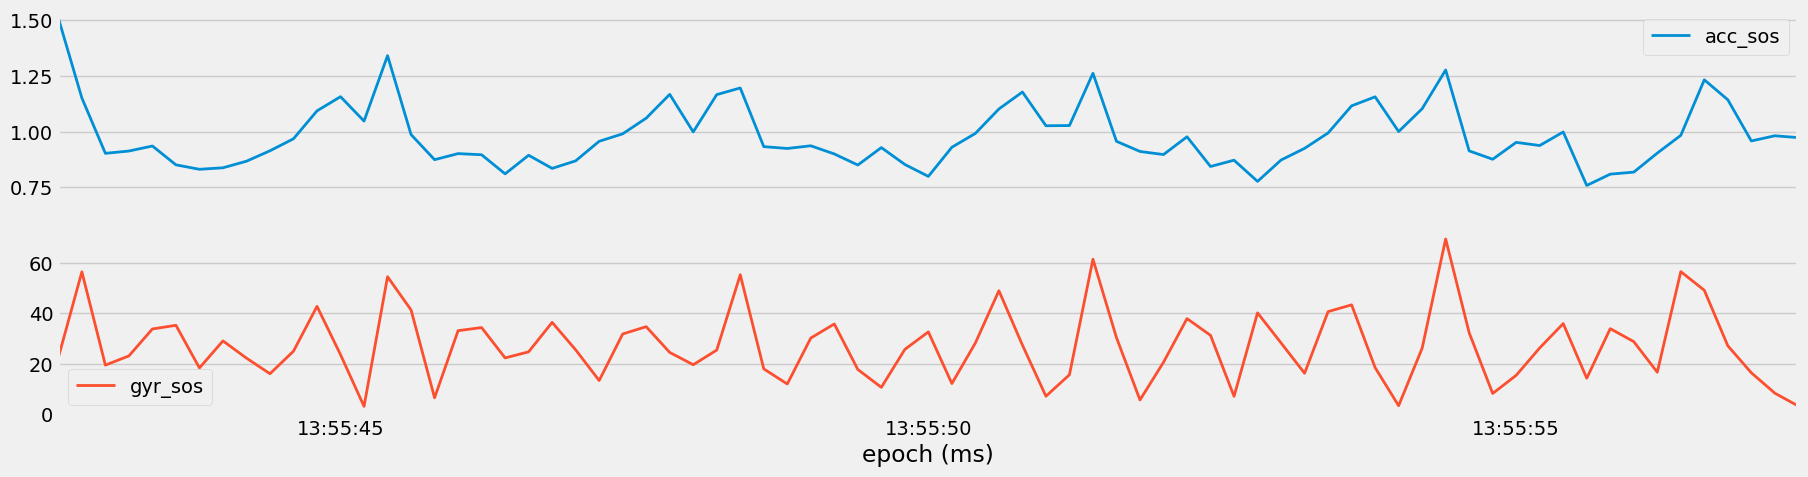

In [174]:
subset = df_sos[df_sos["set"] == 14]
subset[["acc_sos","gyr_sos"]].plot(subplots=True);